In [1]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np

In [3]:
base_dados = pd.read_csv('base_treinamento.txt', encoding = 'utf-8')

In [4]:
base_dados.shape

(196, 2)

In [5]:
base_dados.head(10)

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria
5,adoro seu cabelo macio,alegria
6,adoro a cor dos seus olhos,alegria
7,somo tão amáveis um com o outro,alegria
8,sinto uma grande afeição por ele,alegria
9,quero agradar meus filhos,alegria


In [7]:
base_dados.tail()

,texto,emocao
191,estou chocado e amedrontado com este assassina...,medo
192,é preciso afugenta com ímpeto este medo do inf...,medo
193,políticos usam suas forças para afugentar e am...,medo
194,o objetivo disso e apenas me amedrontar mais,medo
195,isso me apavora,medo


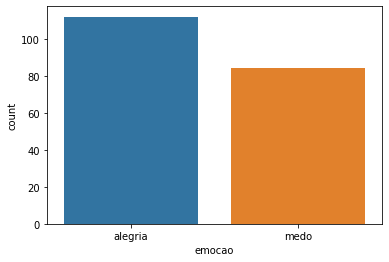

In [8]:
sns.countplot(base_dados['emocao'], label = 'Contagem');

In [9]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS

In [12]:
pln = spacy.load('pt')

In [14]:
def preprocessamento(texto):
    texto = texto.lower()
    documento = pln(texto)
  
    lista = []
    for token in documento:
    #lista.append(token.text)
        lista.append(token.lemma_)

    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

    return lista

In [15]:
teste = preprocessamento('Estou aPrendendo 1 10 23 processamento de linguagem natural, Curso em Curitiba')
teste

'aprender processamento linguagem natural cursar curitiba'

In [16]:
base_dados['texto'] = base_dados['texto'].apply(preprocessamento)

In [17]:
exemplo_base_dados = [["este trabalho é agradável", {"ALEGRIA": True, "MEDO": False}],
                      ["este lugar continua assustador", {"ALEGRIA": False, "MEDO": True}]]

In [18]:
exemplo_base_dados[0]

['este trabalho é agradável', {'ALEGRIA': True, 'MEDO': False}]

In [20]:
base_dados_final = []
for texto, emocao in zip(base_dados['texto'], base_dados['emocao']):
  #print(texto, emocao)
    if emocao == 'alegria':
        dic = ({'ALEGRIA': True, 'MEDO': False})
    elif emocao == 'medo':
        dic = ({'ALEGRIA': False, 'MEDO': True})

    base_dados_final.append([texto, dic.copy()])

In [23]:
base_dados_final[0:10]

[['trabalhar agradável', {'ALEGRIA': True, 'MEDO': False}],
 ['gostar ficar o aconchegar', {'ALEGRIA': True, 'MEDO': False}],
 ['o adesão cursar hoje', {'ALEGRIA': True, 'MEDO': False}],
 ['admirar', {'ALEGRIA': True, 'MEDO': False}],
 ['adorar comer', {'ALEGRIA': True, 'MEDO': False}],
 ['adorar cabelar maciar', {'ALEGRIA': True, 'MEDO': False}],
 ['adorar o cor olho', {'ALEGRIA': True, 'MEDO': False}],
 ['somar amável o outro', {'ALEGRIA': True, 'MEDO': False}],
 ['sentir umar afeição', {'ALEGRIA': True, 'MEDO': False}],
 ['querer agradar filho', {'ALEGRIA': True, 'MEDO': False}]]

In [24]:
modelo = spacy.blank('pt')

In [25]:
categorias = modelo.create_pipe("textcat")
categorias.add_label("ALEGRIA")
categorias.add_label("MEDO")

1

In [26]:
modelo.add_pipe(categorias)

In [27]:
historico = []
modelo.begin_training()
for epoca in range(1000):
    random.shuffle(base_dados_final)
    losses = {}
    for batch in spacy.util.minibatch(base_dados_final, 30):
        textos = [modelo(texto) for texto, entities in batch]
        annotations = [{'cats': entities} for texto, entities in batch]
        modelo.update(textos, annotations, losses=losses)
    if epoca % 100 == 0:
        print(losses)
        historico.append(losses)

{'textcat': 0.006609723495785147}
{'textcat': 1.3150488253899084e-07}
{'textcat': 3.403133930213187e-08}
{'textcat': 1.6079939935131904e-08}
{'textcat': 8.689016228746738e-09}
{'textcat': 5.23868604052069e-09}
{'textcat': 4.232804884374275e-09}
{'textcat': 3.95409605058461e-09}
{'textcat': 3.131640308184913e-09}
{'textcat': 2.9986349098232168e-09}


In [29]:
historico_loss = []
for i in historico:
    historico_loss.append(i.get('textcat'))

In [33]:
historico_loss = np.array(historico_loss)
modelo.to_disk("modelo")

Text(0, 0.5, 'Erro')

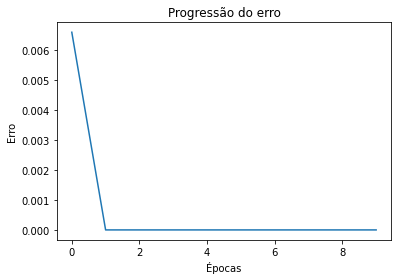

In [34]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [35]:
modelo_carregado = spacy.load("modelo")
modelo_carregado

In [41]:
frase_test = "Me assustei a noite com algo"
texto = preprocessamento(frase_test)

In [42]:
previsao = modelo_carregado(texto)

In [43]:
previsao.cats

{'ALEGRIA': 0.6347335577011108, 'MEDO': 0.19811519980430603}

In [46]:
texto_negativo = 'Estou com medo de algo que vi a noite'
previsao = modelo_carregado(preprocessamento(texto_negativo))
previsao.cats

{'ALEGRIA': 0.05168084055185318, 'MEDO': 0.9184090495109558}

In [48]:
previsoes = []
for texto in base_dados['texto']:
    previsao = modelo_carregado(texto)
    previsoes.append(previsao.cats)

In [49]:
previsoes

[{'ALEGRIA': 0.9995748400688171, 'MEDO': 0.00023173213412519544},
 {'ALEGRIA': 0.9994211196899414, 'MEDO': 0.00019167056598234922},
 {'ALEGRIA': 0.9995241165161133, 'MEDO': 0.0003127055533695966},
 {'ALEGRIA': 0.9997450709342957, 'MEDO': 6.525975913973525e-05},
 {'ALEGRIA': 0.9998975992202759, 'MEDO': 4.539787187241018e-05},
 {'ALEGRIA': 0.9995951056480408, 'MEDO': 0.0001884620141936466},
 {'ALEGRIA': 0.9996371269226074, 'MEDO': 0.0003048497892450541},
 {'ALEGRIA': 0.9997815489768982, 'MEDO': 7.80172340455465e-05},
 {'ALEGRIA': 0.9998477697372437, 'MEDO': 5.1993349188705906e-05},
 {'ALEGRIA': 0.9992287158966064, 'MEDO': 0.0003190919233020395},
 {'ALEGRIA': 0.9997707009315491, 'MEDO': 5.633808905258775e-05},
 {'ALEGRIA': 0.9999545812606812, 'MEDO': 4.539787187241018e-05},
 {'ALEGRIA': 0.9998419284820557, 'MEDO': 9.761789260664955e-05},
 {'ALEGRIA': 0.9993565678596497, 'MEDO': 0.0002798924397211522},
 {'ALEGRIA': 0.9984184503555298, 'MEDO': 0.00045701523777097464},
 {'ALEGRIA': 0.9998911

In [50]:
previsoes_final = []
for previsao in previsoes:
    if previsao['ALEGRIA'] > previsao['MEDO']:
        previsoes_final.append('alegria')
    else:
        previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final)

In [51]:
respostas_reais = base_dados['emocao'].values

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final)

1.0